In [1]:
from gcn_ltsm import *
import numpy as np
import pandas as pd
import tensorflow as tf
print("# GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

def data_preparation(datafile):
    lat_range = {'min': 28.486, 'max': 28.72}
    long_range = {'min': 77.1, 'max': 77.32}
    n_lat_grid = 25
    n_long_grid = 25
    
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @180min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    #taking only data from 6Am-12midnight
    df = df[(df.dateTime>=360)] 
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    df = df.fillna(0)
    return df

def main_forecast(df, gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr, test_date, history_days):
    model = define_model(gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr)
#     history_path = 'results3/scratch/' + test_date
    history_path = None
    trainX, trainY, testX, testY, train_data = prepare_train_data(df)
    out = train_model(model, 100, 19, trainX, trainY, testX, testY, train_data, history_path)
#     out['GCN sizes'] = [gc_sizes]
#     out['LSTM sizes'] = [lstm_sizes]
#     out['History (in days)'] = [history_days]
    out['Test Date'] = [test_date]
    # display(out)
    # test_output, test_true = eval_model(model, testX, testY)
    # plot_predictions(test_output, test_true)
    return model



def main_forecast2(model, df, gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr, test_date, history_days):
    # model = define_model(gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr)
#     history_path = 'results3/fine-tune_lr_004/' + test_date
    history_path = None
    trainX, trainY, testX, testY, train_data = prepare_train_data(df)
    out = train_model(model, 20, 19, trainX, trainY, testX, testY, train_data, history_path)
    # out['GCN sizes'] = [gc_sizes]
    # out['LSTM sizes'] = [lstm_sizes]
    # out['History (in days)'] = [history_days]
#     out['lr'] = lr
    out['Test Date'] = [test_date]
    # display(out)
    # test_output, test_true = eval_model(model, testX, testY)
    # plot_predictions(test_output, test_true)
    return out


2022-07-27 15:40:23.823585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 15:40:23.823712: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# GPUs Available:  []


2022-07-27 15:40:30.083368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 15:40:30.083546: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-27 15:40:30.083642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-07-27 15:40:30.084757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !pip install stellargraph

In [3]:
out_results = pd.DataFrame()
lr_fine = 0.01

## 7 Jan

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


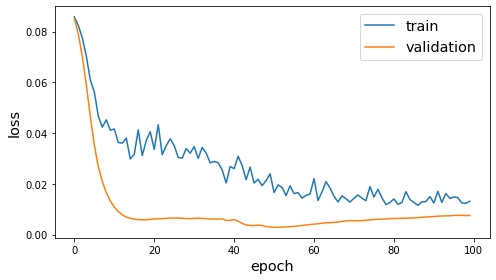

In [4]:
df = data_preparation('PM Datasets/2020-12-31_all.csv')
df1 = data_preparation('PM Datasets/2021-01-01_all.csv')
df = pd.concat([df, df1], axis=1)
df = df.fillna(0)
for i in range(2, 7):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '6 Jan', 6)

,Last Test loss,Test Date
0,29.223507,7 Jan


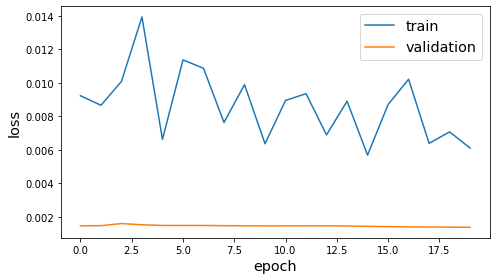

In [5]:
df1 = data_preparation('PM Datasets/2021-01-07_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)

out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '7 Jan', 6)])
out_results

## 10 Jan

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


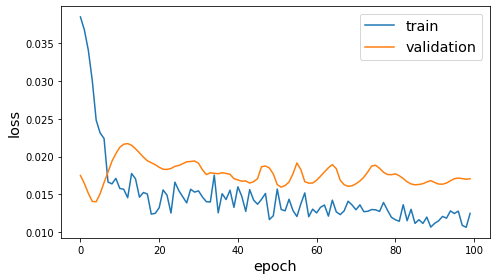

In [6]:
df = data_preparation('PM Datasets/2021-01-03_all.csv')
for i in range(4, 10):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '9 Jan', 6)

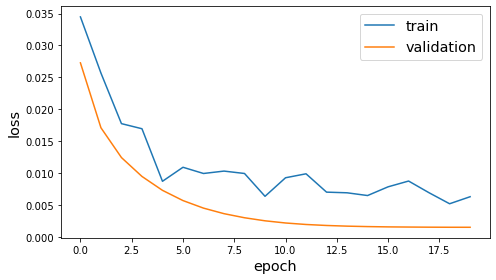

In [7]:
df1 = data_preparation('PM Datasets/2021-01-10_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '10 Jan', 6)])

In [8]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan


## 24 Jan

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


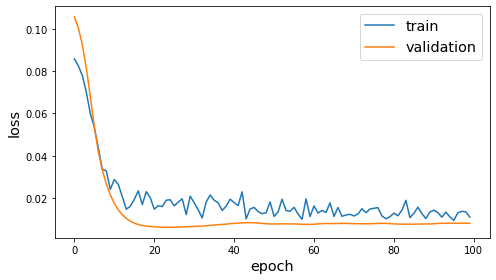

In [9]:
df = data_preparation('PM Datasets/2021-01-17_all.csv')
for i in range(18, 24):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '23 Jan', 6)

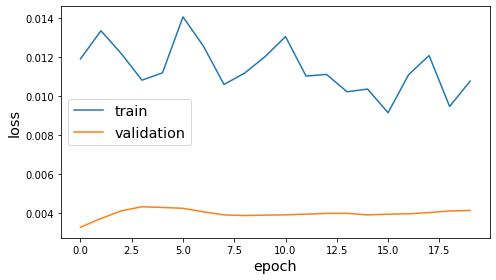

In [10]:
df1 = data_preparation('PM Datasets/2021-01-24_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '24 Jan', 6)])

In [11]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan
0,54.263302,24 Jan


## 15 Dec

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


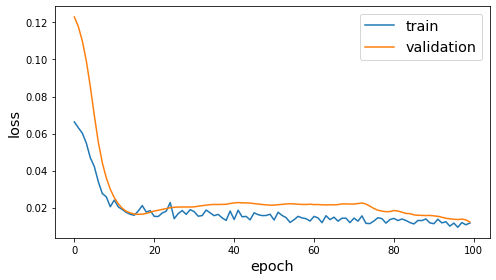

In [12]:
df = data_preparation('PM Datasets/2020-12-08_all.csv')
for i in range(9, 15):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '14 Dec', 6)

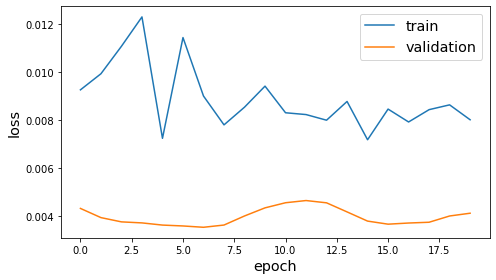

In [13]:
df1 = data_preparation('PM Datasets/2020-12-15_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '15 Dec', 6)])

In [14]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan
0,54.263302,24 Jan
0,43.968078,15 Dec


## 7 dec

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


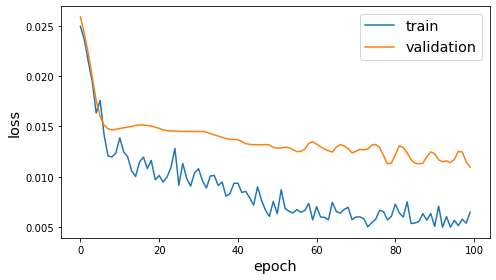

In [15]:
df = data_preparation('PM Datasets/2020-11-30_all.csv')
df1 = data_preparation('PM Datasets/2020-12-01_all.csv')
df = pd.concat([df, df1], axis=1)
df = df.fillna(0)
for i in range(2, 7):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '6 Dec', 6)

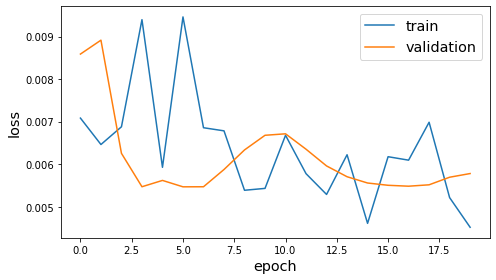

In [16]:
df1 = data_preparation('PM Datasets/2020-12-07_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '7 Dec', 6)])

In [17]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan
0,54.263302,24 Jan
0,43.968078,15 Dec
0,49.934543,7 Dec


## 28 Nov

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


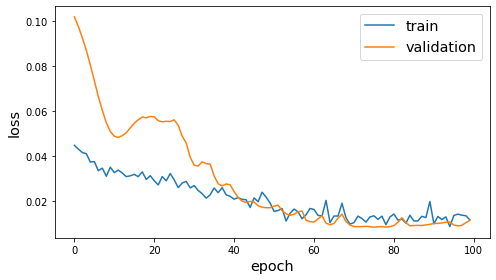

In [18]:
df = data_preparation('PM Datasets/2020-11-21_all.csv')
for i in range(22, 28):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '27 Dec', 6)

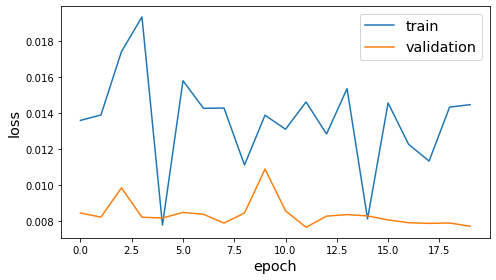

In [19]:
df1 = data_preparation('PM Datasets/2020-11-28_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '28 Nov', 6)])

In [20]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan
0,54.263302,24 Jan
0,43.968078,15 Dec
0,49.934543,7 Dec
0,45.602258,28 Nov


## 20 Nov

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


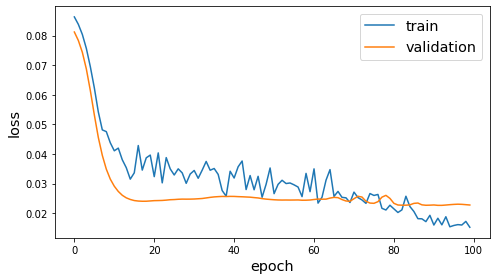

In [21]:
df = data_preparation('PM Datasets/2020-11-13_all.csv')
for i in range(14, 20):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '19 Dec', 6)

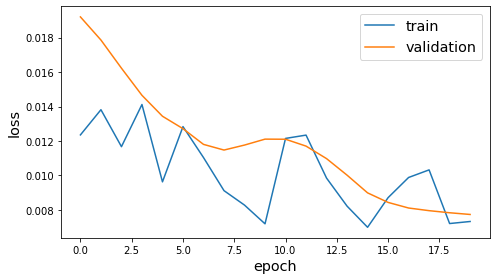

In [22]:
df1 = data_preparation('PM Datasets/2020-11-20_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '20 Nov', 6)])

In [23]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan
0,54.263302,24 Jan
0,43.968078,15 Dec
0,49.934543,7 Dec
0,45.602258,28 Nov
0,58.616067,20 Nov


## 15 Nov

/mnt/c/Users/gauri/Desktop/Pollution/Forecasting-GCN_LSM/gcn_ltsm.py:172: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  lstm_activations = lstm_activations,


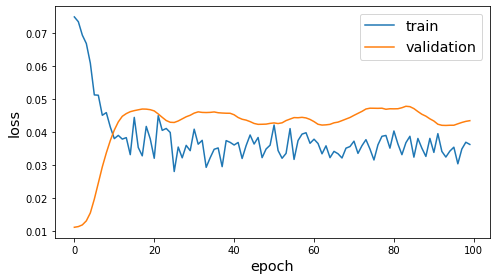

In [24]:
df = data_preparation('PM Datasets/2020-11-08_all.csv')
for i in range(9, 15):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
model = main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '14 Dec', 6)

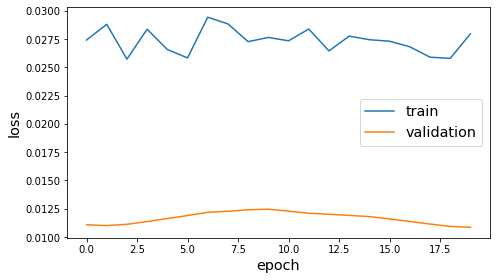

In [25]:
df1 = data_preparation('PM Datasets/2020-11-15_all.csv')
df = pd.concat([df,df1], axis=1).iloc[:, 6:]
df = df.fillna(0)
opt = tf.optimizers.Adam(learning_rate = lr_fine)
model.compile(optimizer=opt, loss=my_loss)
out_results = pd.concat([out_results, main_forecast2(model, df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, '15 Nov', 6)])

In [26]:
out_results

,Last Test loss,Test Date
0,29.223507,7 Jan
0,34.146050,10 Jan
0,54.263302,24 Jan
0,43.968078,15 Dec
0,49.934543,7 Dec
0,45.602258,28 Nov
0,58.616067,20 Nov
0,80.343931,15 Nov
